# MMM API Migration Guide

This guide helps you migrate from the old `MMM` class (`pymc_marketing.mmm.MMM`) to the new multidimensional `MMM` class (`pymc_marketing.mmm.multidimensional.MMM`).

## Why Migrate?

The new `MMM` class provides several improvements:

- **Multidimensional Support**: Native support for hierarchical and multidimensional models
- **Cleaner API**: More explicit model building steps with better separation of concerns
- **Flexible Priors**: Choose between total pooling (shared parameters) or channel-specific priors
- **Enhanced Plotting**: Reorganized plotting API under `mmm.plot.*` namespace
- **Improved Budget Optimization**: New wrapper class for more flexible optimization scenarios

This guide covers all API changes with side-by-side code comparisons to make your migration straightforward.

## 1. Import Path Change

The primary import path has changed:

**Old:**
```python
from pymc_marketing.mmm import MMM
```

**New:**
```python
from pymc_marketing.mmm.multidimensional import MMM
```

The new class is imported from the `multidimensional` submodule during the migration. From version 0.20.0 onwards, the new class is imported from the root `pymc_marketing.mmm.MMM` module.

In [1]:
from pymc_extras.prior import Prior

from pymc_marketing.mmm import MMM as MMM_old
from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM as MMM_new

## 2. Model Initialization & Model Config Defaults

The new `MMM` class initializes is the same as the old one. However, note that the default priors have changed! For the old model we had implicit channel-specific priors, but now we have total pooling by default.

In [2]:
mmm_old = MMM_old(
    date_column="date_week",
    channel_columns=["x1", "x2"],
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
)

mmm_old.model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

In [3]:
mmm_new = MMM_new(
    date_column="date_week",
    channel_columns=["x1", "x2"],
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
)

mmm_new.model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1),
 'saturation_beta': Prior("HalfNormal", sigma=2)}

You can explicitly specify the model config for just these variables to get the old behavior.

In [4]:
my_model_config = {
    "adstock_alpha": Prior("Beta", alpha=1, beta=3, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=3, beta=1, dims="channel"),
    "saturation_beta": Prior("HalfNormal", sigma=2, dims="channel"),
}

mmm_new = MMM_new(
    date_column="date_week",
    channel_columns=["x1", "x2"],
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    model_config=my_model_config,
)

mmm_new.model_config == mmm_old.model_config

True

### When to Use Each Approach

| Approach | Use Case |
|----------|----------|
| **Total Pooling** (new default) | When you expect similar adstock/saturation behavior across channels, or have limited data per channel |
| **Channel-Specific** | When channels have fundamentally different response characteristics (e.g., TV vs. digital) |

## 3. Adding Original Scale Variables to the Inference Data 

The new API allows you to store variable contribution in the original scale in the inference data attribute.
```python
mmm = MMM(...)

# Step 1: Build the model explicitly
mmm.build_model(X_train, y_train)

# Step 2: Add original scale contribution variables (optional but recommended)
mmm.add_original_scale_contribution_variable(var=["channel_contribution", "y"])

# Step 3: Fit the model
mmm.fit(X_train, y_train)
```

### Why `add_original_scale_contribution_variable()`?

This method stores unscaled (original scale) contribution variables in `idata["posterior"]`. This is particularly useful when:

- You want to analyze contributions in the original units (dollars, impressions, etc.)
- You need to compare contributions across different scales

Without this call, you would need to manually reverse the scaling transformation during analysis.

## 5. Parameter Naming Changes

Some internal parameter names have changed. Update your code if you access parameters directly:

| Old Name | New Name |
|----------|----------|
| `intercept` | `intercept_contribution` |

**Example:**

```python
# Old
az.summary(mmm.fit_result, var_names=["intercept"])

# New
az.summary(mmm.fit_result, var_names=["intercept_contribution"])
```

## 6. Plotting API Changes

### New Access Pattern

Plotting functions are now accessed through the `plot` attribute:

**Old:**
```python
mmm.plot_prior_predictive(...)
mmm.plot_posterior_predictive(...)
```

**New:**
```python
mmm.plot.prior_predictive(...)
mmm.plot.posterior_predictive(...)
```

### Renamed Functions

Several plotting functions have been renamed for clarity:

| Old Function | New Function |
|--------------|--------------|
| `plot_components_contributions` | `plot.contributions_over_time` |
| `plot_direct_contribution_curves` | `plot.saturation_scatterplot` |
| `plot_channel_contribution_grid` | `plot.sensitivity_analysis` |

### Examples

**Contributions over time:**
```python
# Old
fig = mmm.plot_components_contributions(original_scale=True)

# New
fig = mmm.plot.contributions_over_time()
```

**Saturation curves:**
```python
# Old
fig = mmm.plot_direct_contribution_curves()

# New
fig = mmm.plot.saturation_scatterplot()
```

### Channel-Specific Parameter Plots

For channel-specific parameters, use ArviZ directly:

```python
import arviz as az

# Plot posterior for channel-specific parameters
az.plot_posterior(
    mmm.fit_result,
    var_names=["adstock_alpha", "saturation_lam"],
    coords={"channel": mmm.channel_columns}
)
```

## 7. Sensitivity Analysis Workflow

Sensitivity analysis now follows a two-step process, separating computation from visualization.

### Old Approach (Single Function)

```python
# Old - computation and plotting combined
fig = mmm.plot_channel_contribution_grid(start=0, stop=1.5, num=12)
```

### New Approach (Two Steps)

```python
import numpy as np

# Step 1: Run the sensitivity sweep (stores results in idata)
mmm.sensitivity.run_sweep(
    sweep_values=np.linspace(0, 1.5, 12),
    var_name="channel_contribution",
)

# Step 2: Visualize the results
fig = mmm.plot.sensitivity_analysis()
```

### Benefits of the New Approach

1. **Reusable Results**: Sweep results are stored in `idata["sensitivity_analysis"]` and can be accessed later
2. **Flexible Visualization**: Plot the same results in different ways without re-running the sweep
3. **Custom Analysis**: Access raw sweep results for custom analysis:

```python
# Access sensitivity results directly
sensitivity_data = mmm.idata["sensitivity_analysis"]
```

## 8. Budget Optimization Changes

Budget optimization now uses a dedicated wrapper class for more flexibility.

### Old Approach

```python
# Old - direct method on MMM
allocation, result = mmm.optimize_budget(
    budget=1000,
    num_days=30,
    budget_bounds={"x1": [0, 500], "x2": [0, 500]},
)
```

### New Approach

```python
import xarray as xr
from pymc_marketing.mmm.multidimensional import MultiDimensionalBudgetOptimizerWrapper

# Step 1: Create the optimizer wrapper with date range
optimizable_model = MultiDimensionalBudgetOptimizerWrapper(
    model=mmm,
    start_date="2023-01-01",
    end_date="2023-12-31",
)

# Step 2: Define budget bounds as xarray DataArray
budget_bounds = xr.DataArray(
    data=[[0, 500], [0, 500]],
    dims=["channel", "bound"],
    coords={
        "channel": ["x1", "x2"],
        "bound": ["lower", "upper"],
    },
)

# Step 3: Run optimization
allocation, result = optimizable_model.optimize_budget(
    budget=1000,
    budget_bounds=budget_bounds,
)

# Step 4: Visualize results
fig = optimizable_model.plot.budget_allocation()
```

### Key Differences

| Aspect | Old | New |
|--------|-----|-----|
| **Budget bounds** | Dictionary | `xarray.DataArray` |
| **Date range** | `num_days` parameter | `start_date`/`end_date` in wrapper |
| **Plotting** | `mmm.plot_budget_allocation()` | `optimizable_model.plot.budget_allocation()` |

### Benefits of the New Approach

1. **Time-Aware Optimization**: Specify exact date ranges for optimization
2. **Multidimensional Bounds**: Use xarray for complex constraint structures (e.g., time-varying bounds)
3. **Separation of Concerns**: Optimization logic is separate from the core model

## 9. Complete Example

Here's a minimal end-to-end example using the new API:

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymc_extras.prior import Prior

from pymc_marketing.mmm.components.adstock import GeometricAdstock
from pymc_marketing.mmm.components.saturation import LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam, saturation_beta, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


Output()

Sampling: [y]


Output()

(<Figure size 1200x700 with 1 Axes>,
 array([[<Axes: title={'center': 'Time Series Contributions'}, xlabel='Date', ylabel='Posterior Value'>]],
       dtype=object))

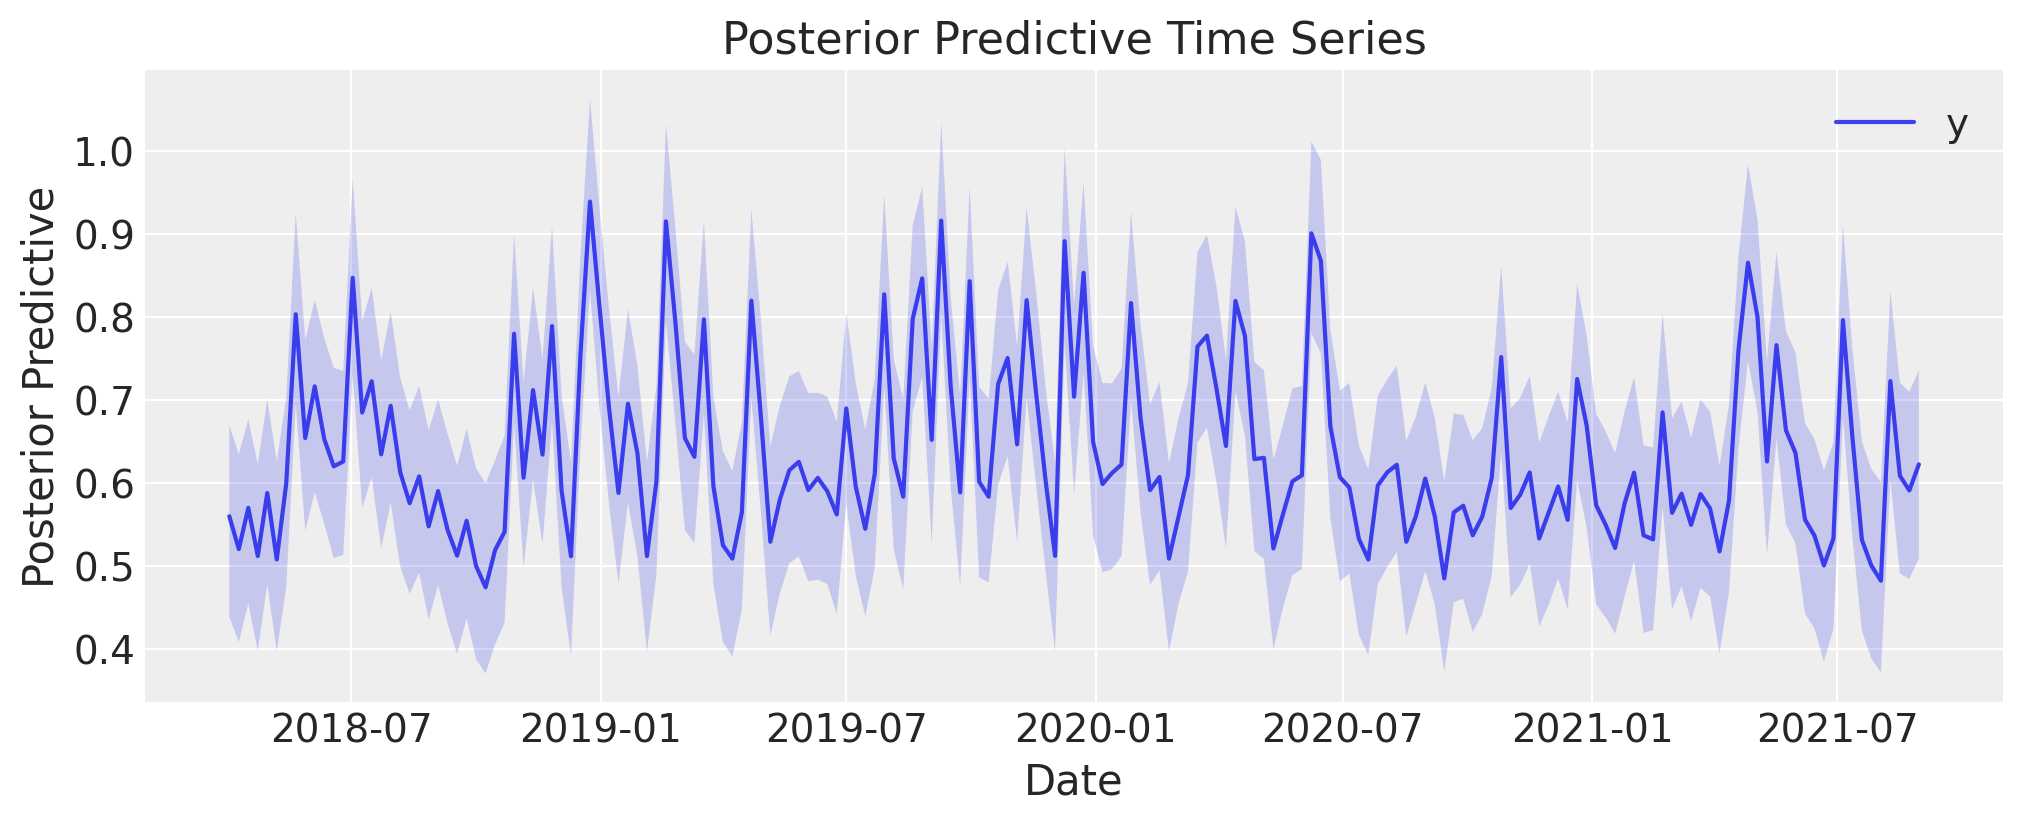

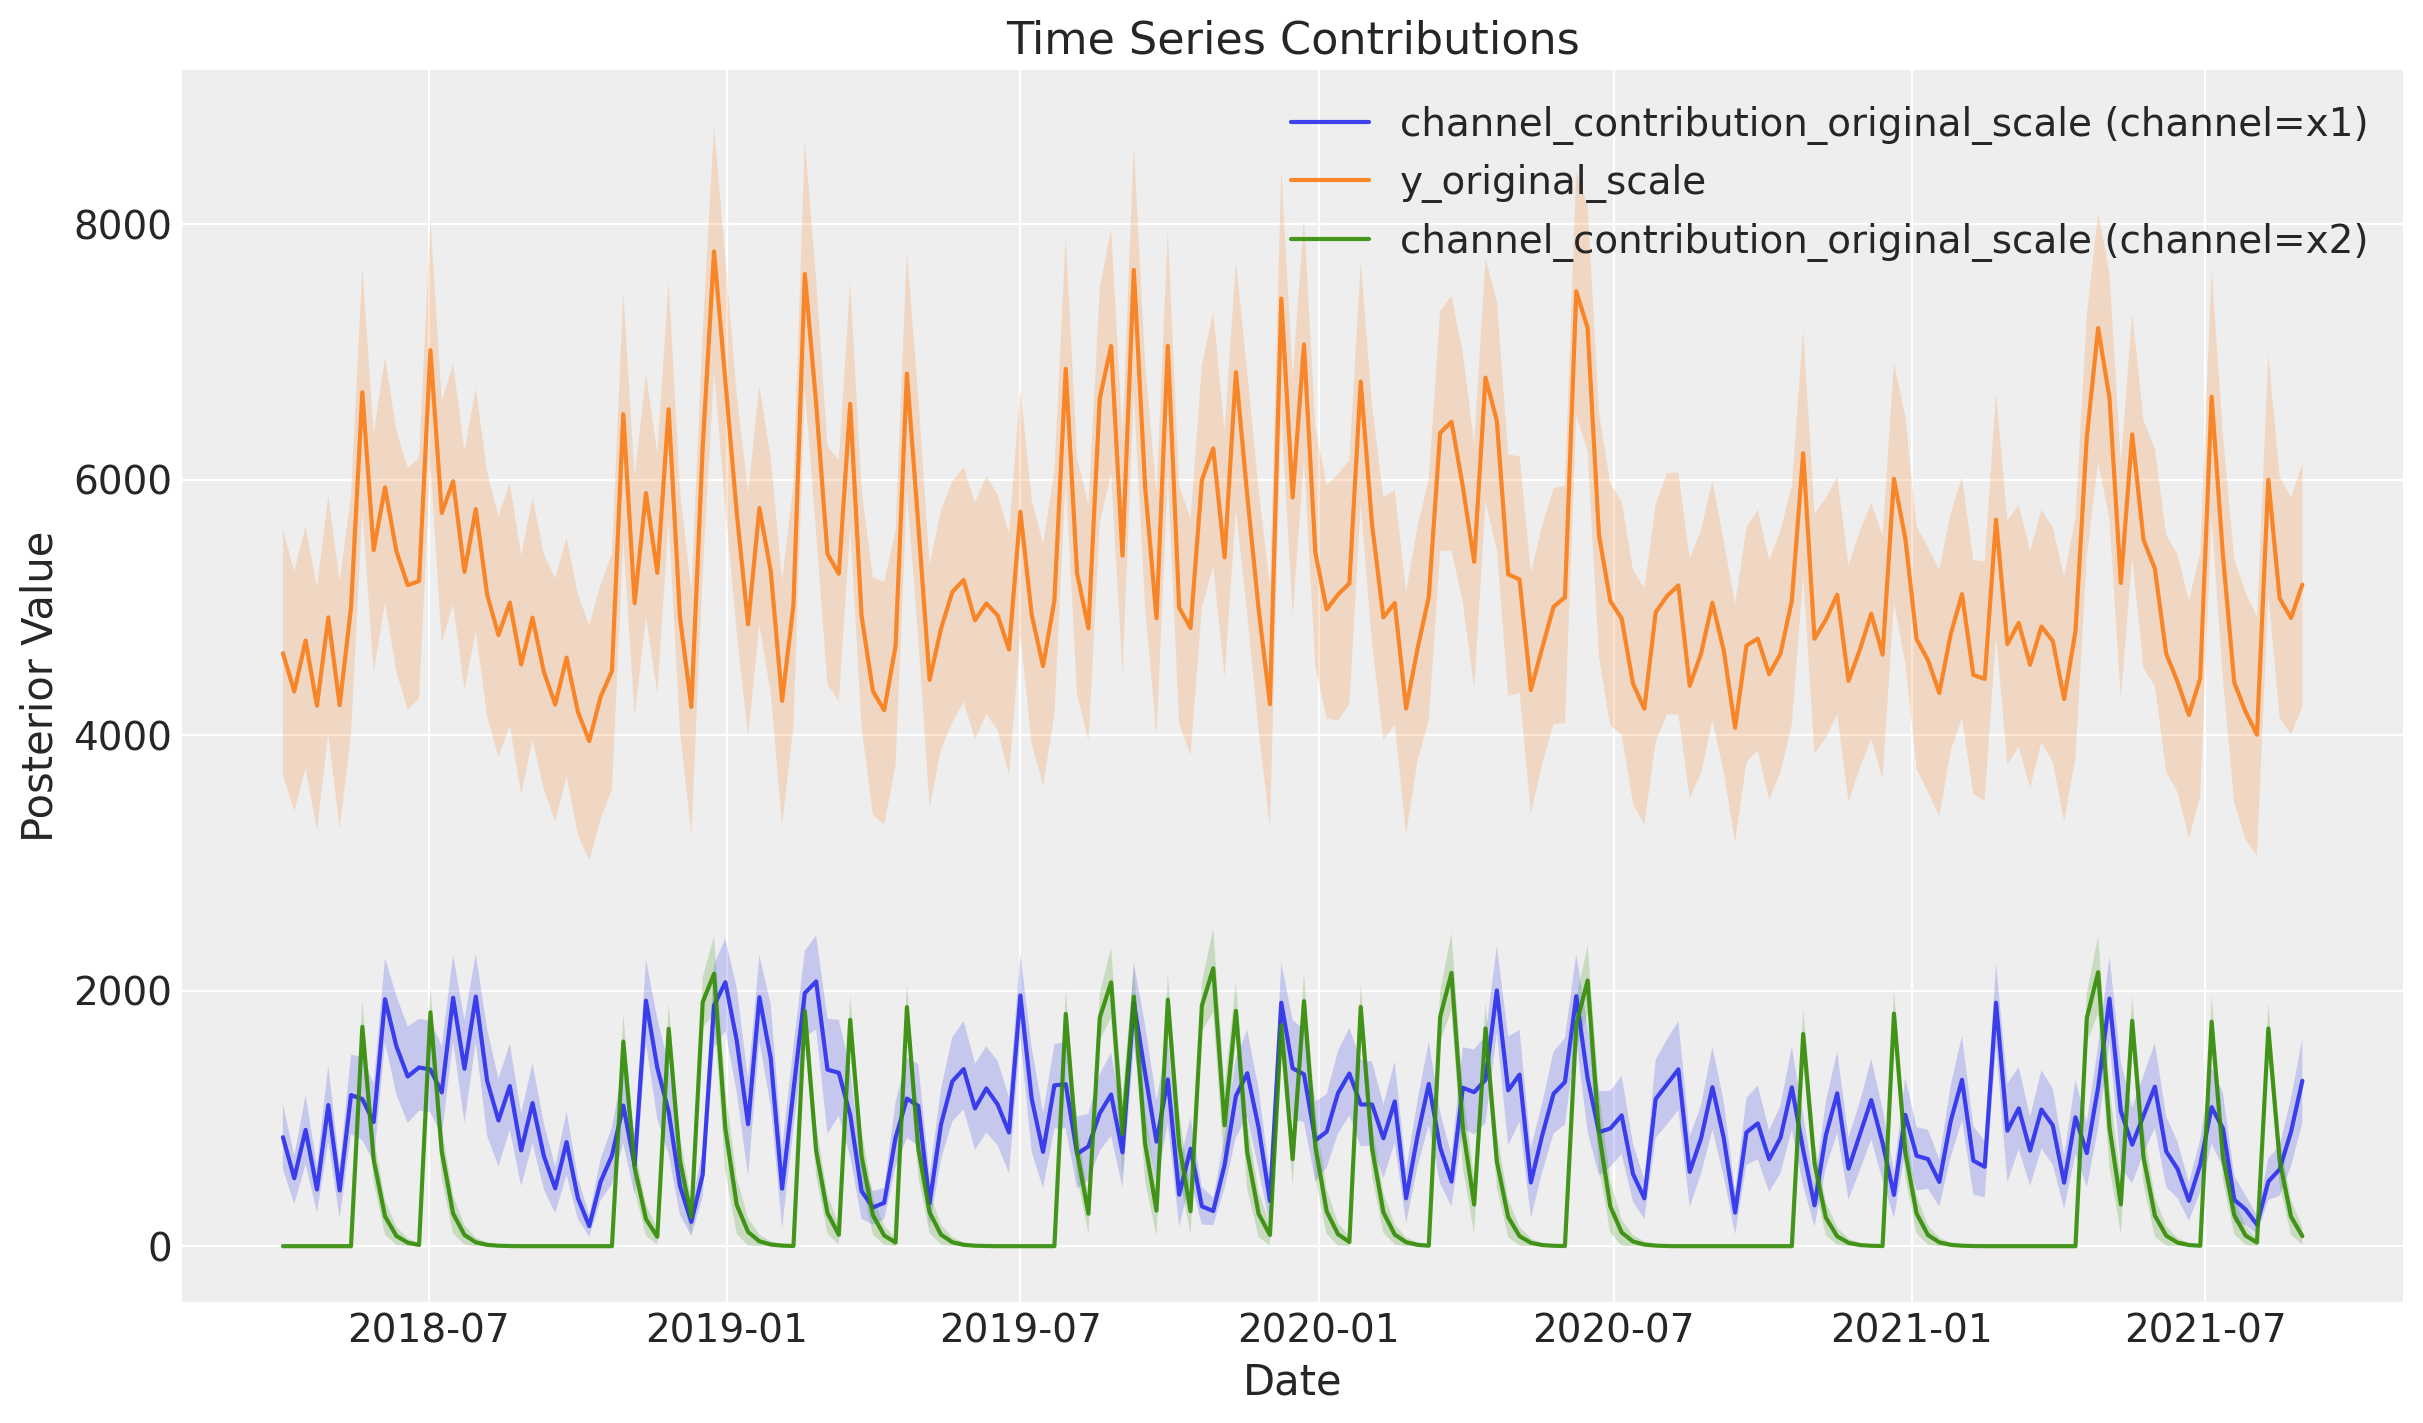

In [6]:
# Load sample data
data_url = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/mmm_example.csv"
data = pd.read_csv(data_url, parse_dates=["date_week"])

# Define channel columns
channel_columns = ["x1", "x2"]

# Optional: Define channel-specific priors (to match old default behavior)
model_config = {
    "adstock_alpha": Prior("Beta", alpha=1, beta=3, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=3, beta=1, dims="channel"),
    "saturation_beta": Prior("HalfNormal", sigma=2, dims="channel"),
}

# Create the model (new API)
mmm = MMM(
    date_column="date_week",
    channel_columns=channel_columns,
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    model_config=model_config,  # Optional: for channel-specific priors
)

# Prepare data
X = data[["date_week", *channel_columns]]
y = data["y"]

# Build model explicitly (new step)
mmm.build_model(X, y)

# Add original scale contribution variables (recommended)
mmm.add_original_scale_contribution_variable(var=["channel_contribution", "y"])

# Fit the model
mmm.fit(X, y, chains=4, draws=1_000, target_accept=0.9, random_seed=rng)
mmm.sample_posterior_predictive(X, random_seed=rng)


# Analyze results using the new plotting API
mmm.plot.posterior_predictive()
mmm.plot.contributions_over_time(
    var=["channel_contribution_original_scale", "y_original_scale"],
    combine_dims=True,
    figsize=(12, 7),
)

## 10. Quick Reference Summary

### Import Changes

| Old | New |
|-----|-----|
| `from pymc_marketing.mmm import MMM` | `from pymc_marketing.mmm.multidimensional import MMM` |

### Model Building

| Old | New |
|-----|-----|
| Implicit (during `fit()`) | Explicit: `build_model()` then `add_original_scale_contribution_variable()` |

### Prior Defaults

| Behavior | Old | New |
|----------|-----|-----|
| Default | Channel-specific (`dims="channel"`) | Total pooling (shared) |
| Channel-specific | Implicit | Add `dims="channel"` to `model_config` |

### Parameter Names

| Old | New |
|-----|-----|
| `intercept` | `intercept_contribution` |

### Plotting API

| Old | New |
|-----|-----|
| `mmm.plot_*()` | `mmm.plot.*()` |
| `plot_components_contributions` | `plot.contributions_over_time` |
| `plot_direct_contribution_curves` | `plot.saturation_scatterplot` |
| `plot_channel_contribution_grid` | `plot.sensitivity_analysis` |

### Sensitivity Analysis

| Old | New |
|-----|-----|
| `mmm.plot_channel_contribution_grid(...)` | `mmm.sensitivity.run_sweep(...)` then `mmm.plot.sensitivity_analysis()` |

### Budget Optimization

| Old | New |
|-----|-----|
| `mmm.optimize_budget(...)` | `MultiDimensionalBudgetOptimizerWrapper(model=mmm, ...).optimize_budget(...)` |
| `budget_bounds` as dict | `budget_bounds` as `xarray.DataArray` |
| `num_days` parameter | `start_date`/`end_date` in wrapper constructor |

In [7]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri, 06 Feb 2026

Python implementation: CPython
Python version       : 3.13.12
IPython version      : 9.10.0

arviz         : 0.23.4
matplotlib    : 3.10.8
numpy         : 2.3.5
pandas        : 2.3.3
pymc_extras   : 0.8.0
pymc_marketing: 0.17.1

Watermark: 2.6.0

